In [3]:
# Importing libraries for data handling, visualization, and deep learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob 
from skimage.io import imread
import cv2
from PIL import Image
from skimage.transform import resize
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import save_model

In [5]:
df = pd.read_csv('emotions.csv')
df

set_id  gender  age country
0        0  FEMALE   36      RU
1        1  FEMALE   37      RU
2        2  FEMALE   36      RU
3        3    MALE   29      RU
4        4  FEMALE   43      RU
5        5    MALE   49      RU
6        6  FEMALE   38      RU
7        7    MALE   19      PH
8        8  FEMALE   29      RU
9        9  FEMALE   32      RU
10      10    MALE   33      IN
11      11  FEMALE   15      RU
12      12  FEMALE   34      RU
13      13  FEMALE   43      RU
14      14  FEMALE   20      RU
15      15  FEMALE   18      RU
16      16  FEMALE   37      RU
17      17  FEMALE   24      RU
18      18    MALE   19      RU

In [6]:
# Descriptive statistics of the dataset
df.describe()

set_id        age
count  19.000000  19.000000
mean    9.000000  31.105263
std     5.627314   9.683289
min     0.000000  15.000000
25%     4.500000  22.000000
50%     9.000000  33.000000
75%    13.500000  37.000000
max    18.000000  49.000000

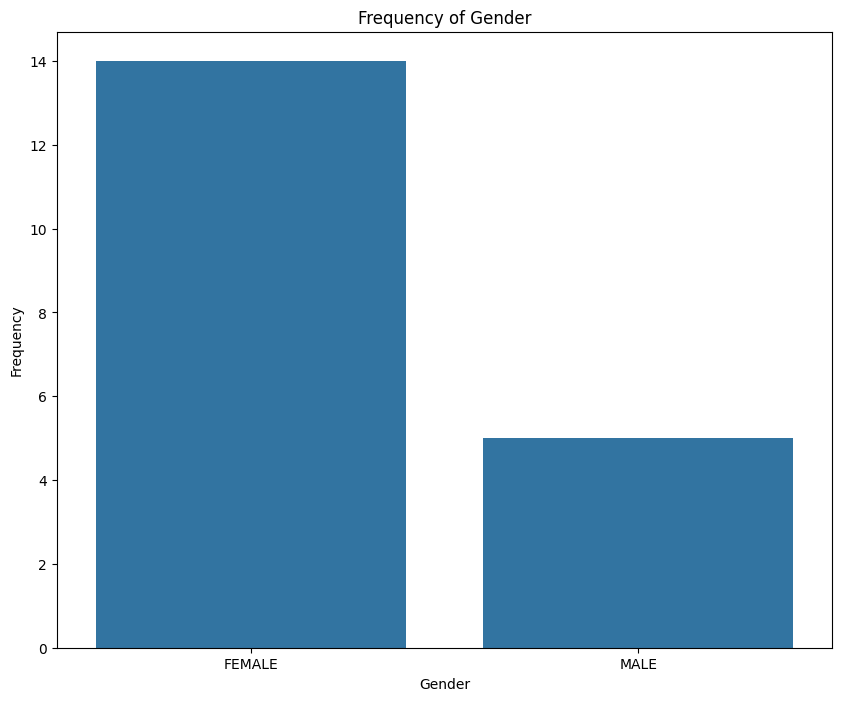

In [7]:
# Plotting the frequency of gender
plt.figure(figsize=(10, 8))
sns.barplot(x=df['gender'].value_counts().index, y=df['gender'].value_counts())
plt.title('Frequency of Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()

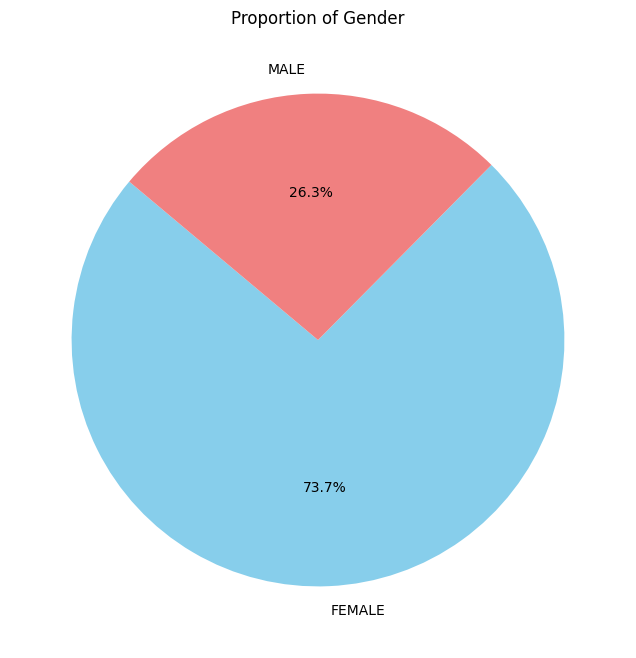

In [8]:
# Plotting the proportion of gender using a pie chart
plt.figure(figsize=(10, 8))
plt.pie(df['gender'].value_counts(), labels=df['gender'].value_counts().index, autopct='%1.1f%%', startangle=140,
        colors=['skyblue', 'lightcoral'])
plt.title('Proportion of Gender')
plt.show()

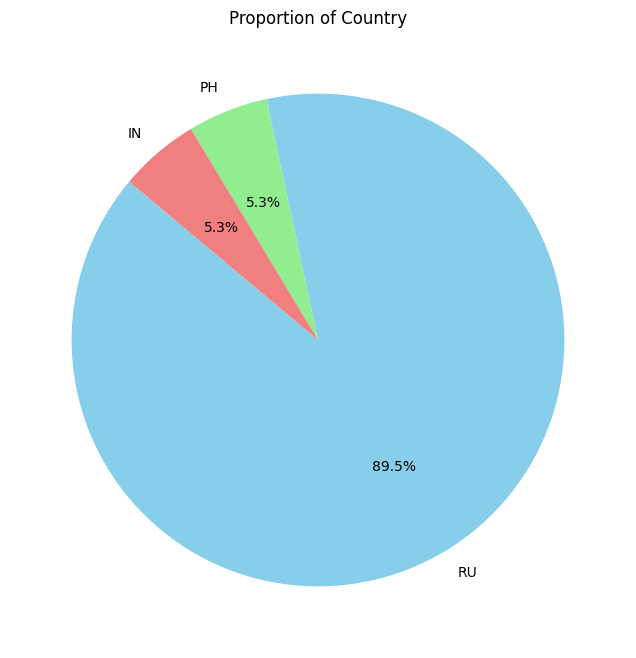

In [9]:
# Plotting the proportion of country using a pie chart
plt.figure(figsize=(10, 8))
plt.pie(df['country'].value_counts(), labels=df['country'].value_counts().index, autopct='%1.1f%%', startangle=140,
        colors=['skyblue', 'lightgreen','lightcoral'])
plt.title('Proportion of Country')
plt.show()

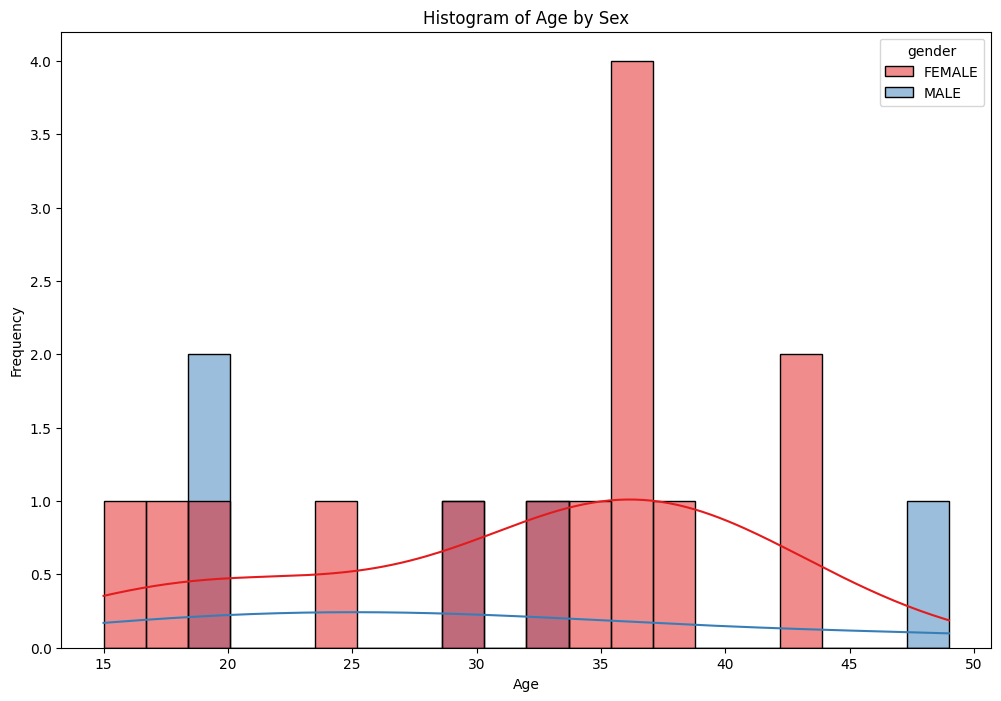

In [10]:
# Visualizing the age distribution by gender
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='age', hue='gender', palette='Set1', kde=True, bins=20)
plt.title('Histogram of Age by Sex')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

<Figure size 1000x800 with 0 Axes>

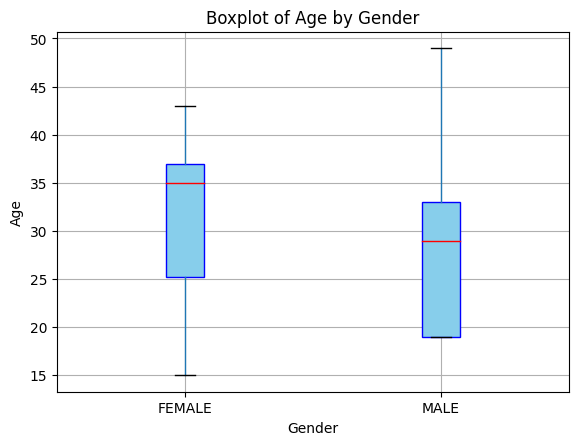

In [11]:
# Boxplot for age distribution by gender
plt.figure(figsize=(10, 8))
df.boxplot(column='age', by='gender', patch_artist=True, boxprops=dict(facecolor='skyblue', color='blue'),
           medianprops=dict(color='red'))
plt.title('Boxplot of Age by Gender')
plt.suptitle('')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

In [13]:
# Loading image paths
images = glob.glob('images/*/*.jpg')
print(len(images)) # Total number of images
print(images[0]) # Example path

152
images\0\Anger.jpg


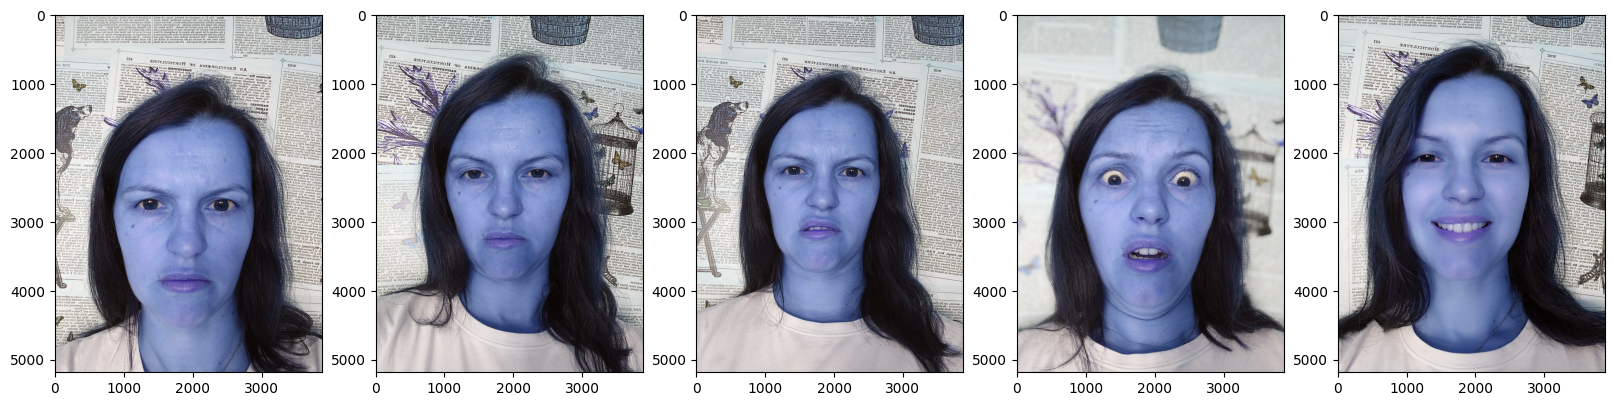

In [14]:
# Displaying some sample images
fig, axes = plt.subplots(1, 5, figsize=(20, 10))  
for i in range(5):
    img = cv2.imread(images[i])
    axes[i].imshow(img)      
plt.show()

In [15]:
# Creating a DataFrame for image paths and their respective emotions
image_data = pd.DataFrame(index=np.arange(0, len(images)), columns=['path', 'emotion'])
for i in range(len(images)):
    image_data.loc[i, 'path'] = images[i]
    image_data.loc[i, 'emotion'] = images[i][50:].replace(images[i][-4:], '')

In [16]:
image_data

path emotion
0        images\0\Anger.jpg        
1     images\0\Contempt.jpg        
2      images\0\Disgust.jpg        
3         images\0\Fear.jpg        
4        images\0\Happy.jpg        
..                      ...     ...
147       images\9\Fear.jpg        
148      images\9\Happy.jpg        
149    images\9\Neutral.jpg        
150        images\9\Sad.jpg        
151  images\9\Surprised.jpg        

[152 rows x 2 columns]

In [17]:
# Standardizing the emotion column values by removing unnecessary prefixes to ensure consistency in emotion labels.
image_data['emotion'] = image_data['emotion'].replace('/Surprised', 'Surprised')
image_data['emotion'] = image_data['emotion'].replace('/Happy', 'Happy')
image_data['emotion'] = image_data['emotion'].replace('/Sad', 'Sad')
image_data['emotion'] = image_data['emotion'].replace('/Anger', 'Anger')
image_data['emotion'] = image_data['emotion'].replace('/Neutral', 'Neutral')
image_data['emotion'] = image_data['emotion'].replace('/Fear', 'Fear')
image_data['emotion'] = image_data['emotion'].replace('/Contempt', 'Contempt')
image_data['emotion'] = image_data['emotion'].replace('/Disgust', 'Disgust')

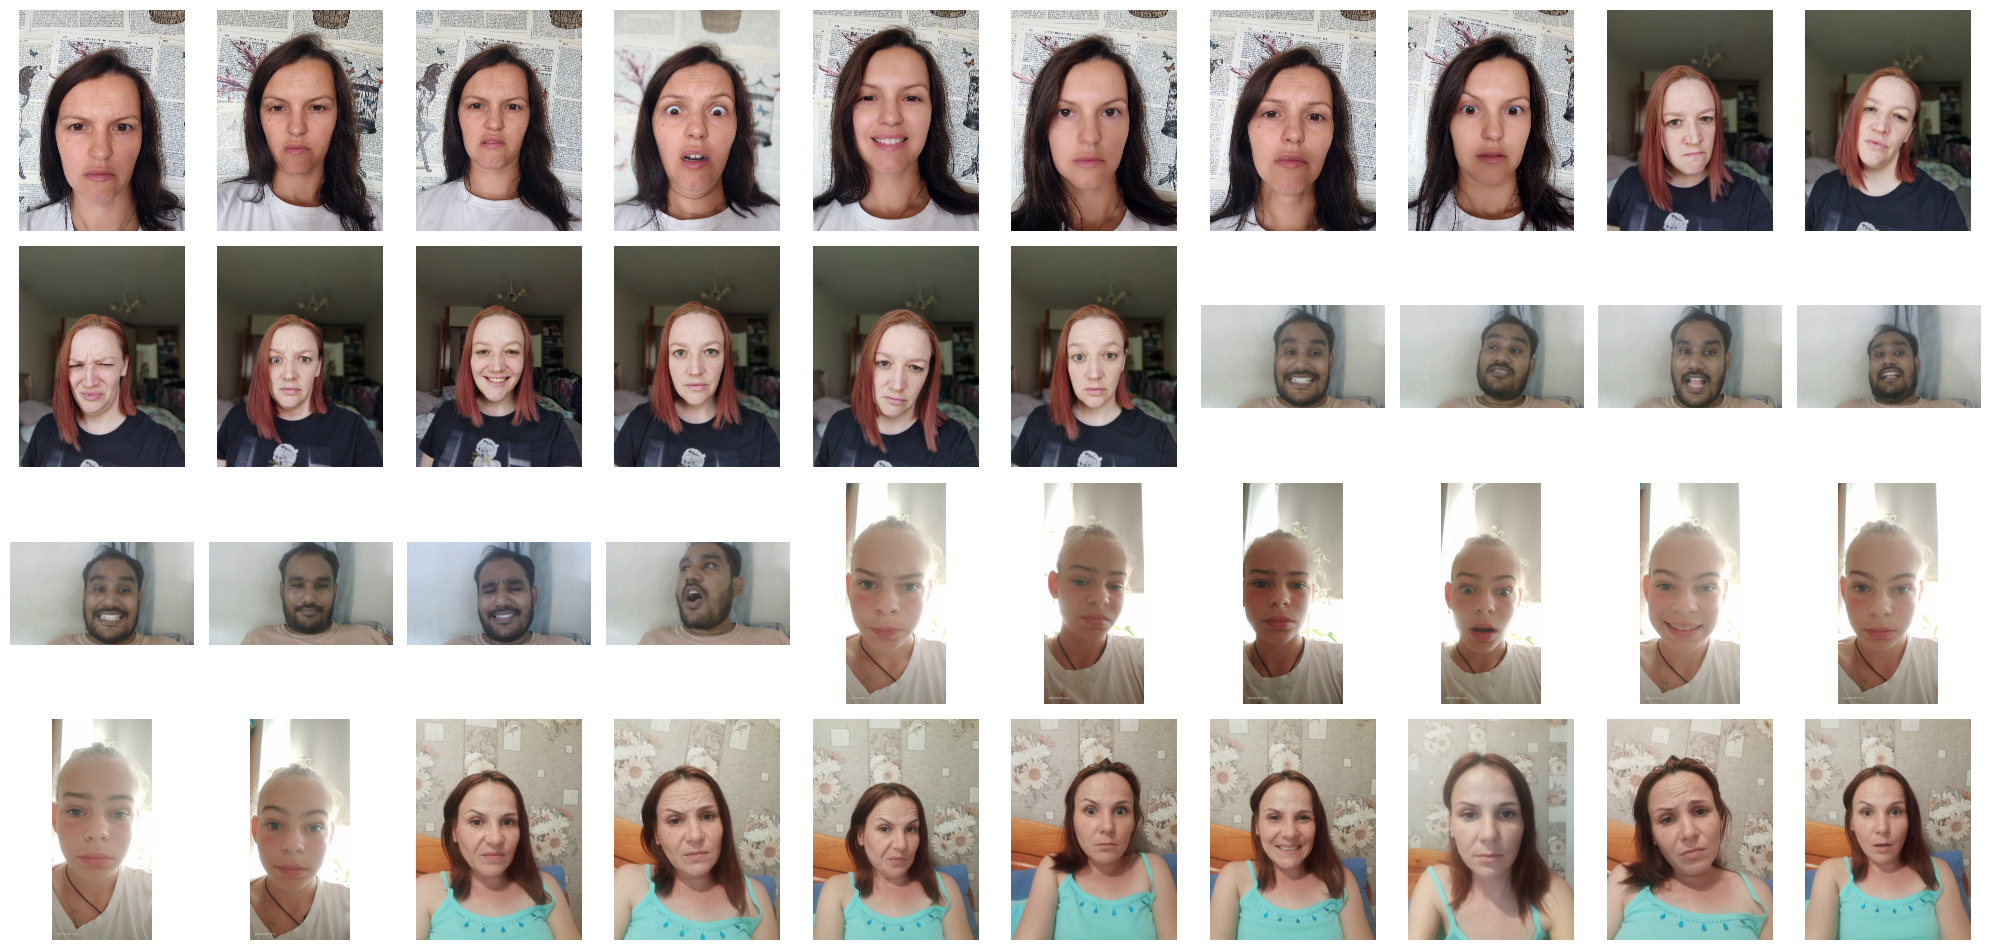

In [18]:
# Displaying a grid of 40 images (4 rows and 10 columns) with their corresponding emotion labels
fig, axes = plt.subplots(4, 10, figsize=(20, 10))
for i in range(4):
    for j in range(10):        
        image = imread(image_data.iloc[j + 10*i]["path"])
        axes[i, j].imshow(image)
        label = image_data.iloc[j + 10*i]["emotion"]
        axes[i, j].set_title(label, fontsize=8) 
        axes[i, j].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

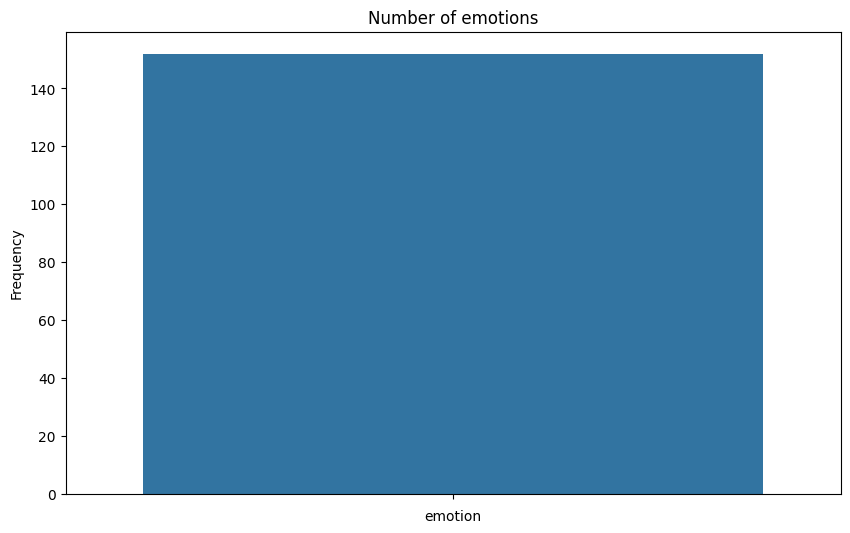

In [22]:
# Plotting the distribution of emotions to visualize the frequency of each emotion label in the dataset
plt.figure(figsize=(10, 6))
sns.barplot(x=image_data['emotion'].value_counts().index, y=image_data['emotion'].value_counts())
plt.title('Number of emotions')
plt.xlabel('emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [23]:
# Encoding the emotion labels as integers using LabelEncoder
label_encoder = LabelEncoder()
image_data['emotion'] = label_encoder.fit_transform(image_data['emotion'])

In [24]:
image_data

path  emotion
0        images\0\Anger.jpg        0
1     images\0\Contempt.jpg        0
2      images\0\Disgust.jpg        0
3         images\0\Fear.jpg        0
4        images\0\Happy.jpg        0
..                      ...      ...
147       images\9\Fear.jpg        0
148      images\9\Happy.jpg        0
149    images\9\Neutral.jpg        0
150        images\9\Sad.jpg        0
151  images\9\Surprised.jpg        0

[152 rows x 2 columns]

In [25]:
# Loading and resizing images to 224x224 pixels and preparing feature (X) and label (y) arrays
X = []
y = []
for feature, label in image_data.values:
    image = cv2.imread(feature)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
    X.append(image)
    y.append(label)
X = np.array(X)
y = np.array(y)

In [26]:
# Print shape of input data (X) and output data (y)
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (152, 224, 224, 3)
Shape of y: (152,)


In [27]:
# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,        
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    shear_range=0.2,          
    zoom_range=0.2,           
    horizontal_flip=True,     
    fill_mode='nearest'       
)

In [28]:
# Applying augmentation to images
augmented_X = []
augmented_y = []
for i in range(len(X)):
    img = X[i].reshape((1, *X[i].shape))  
    label = y[i]
    for _ in range(50):  
        augmented = next(datagen.flow(img, batch_size=1))
        augmented_X.append(augmented[0])  
        augmented_y.append(label)        
augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

In [29]:
# Combining original and augmented data
X = np.concatenate([X, augmented_X], axis=0)
y = np.concatenate([y, augmented_y], axis=0)

In [30]:
# Print shape of input data (X) and output data (y) after augmentation
print(X.shape)  
print(y.shape)

(7752, 224, 224, 3)
(7752,)


In [31]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [32]:
print(f'Length of Training Data: {len(X_train)}')
print(f'Length of Testing Data: {len(X_test)}')

Length of Training Data: 6201
Length of Testing Data: 1551


In [33]:
y_train = to_categorical(y_train, num_classes = 8)
y_test = to_categorical(y_test, num_classes = 8)

In [34]:
# Building the model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, mode='max', verbose=1, factor=0.5, min_lr=0.0001)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(8, activation='softmax')
])

94765736/94765736 [==============================] - 5s 0us/step


In [35]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                        

In [36]:
# Training the model
history = model.fit(
    X_train, y_train, batch_size=20, validation_data=(X_test, y_test), epochs=25, callbacks=[early_stopping, lr_reduction]
)

Epoch 1/25
311/311 [==============================] - 293s 926ms/step - loss: 0.0101 - accuracy: 0.9968 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/25
311/311 [==============================] - 305s 980ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/25
311/311 [==============================] - 307s 987ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/25
311/311 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
311/311 [==============================] - 313s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/25
311/311 [==============================] - 332s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 

In [37]:
# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
print("Loss:", loss)

49/49 [==============================] - 98s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Accuracy: 1.0
Loss: 0.0


In [38]:
# Classification report
y_pred = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

49/49 [==============================] - 49s 969ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1551

    accuracy                           1.00      1551
   macro avg       1.00      1.00      1.00      1551
weighted avg       1.00      1.00      1.00      1551



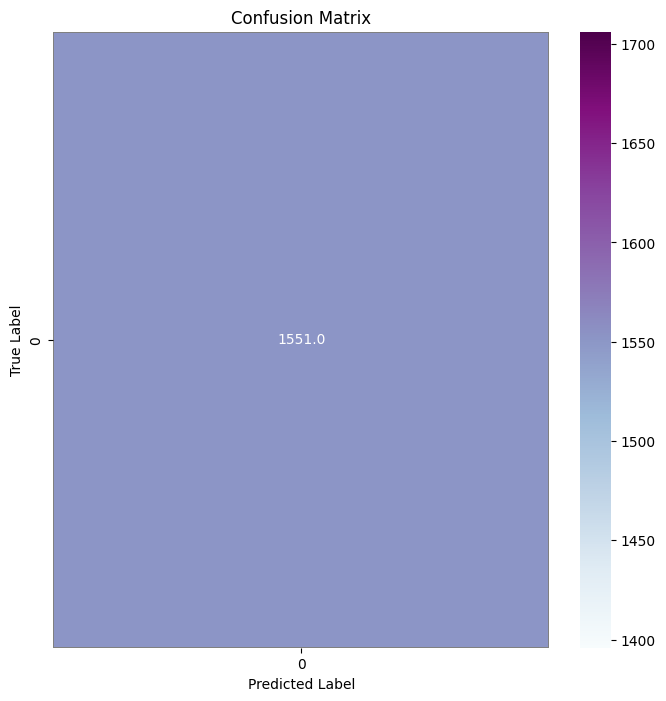

In [39]:
# Confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

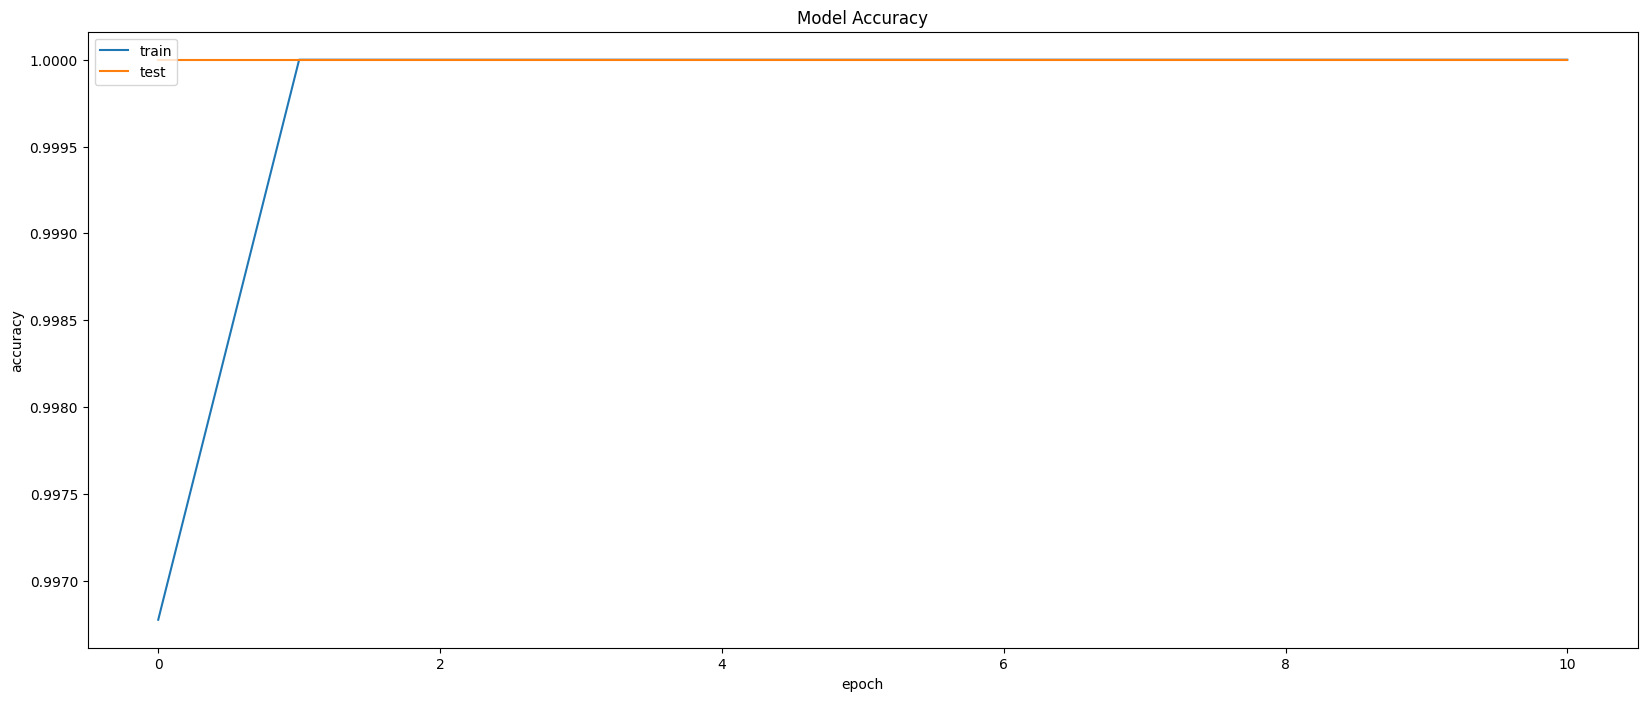

In [40]:
# Accuracy plot
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

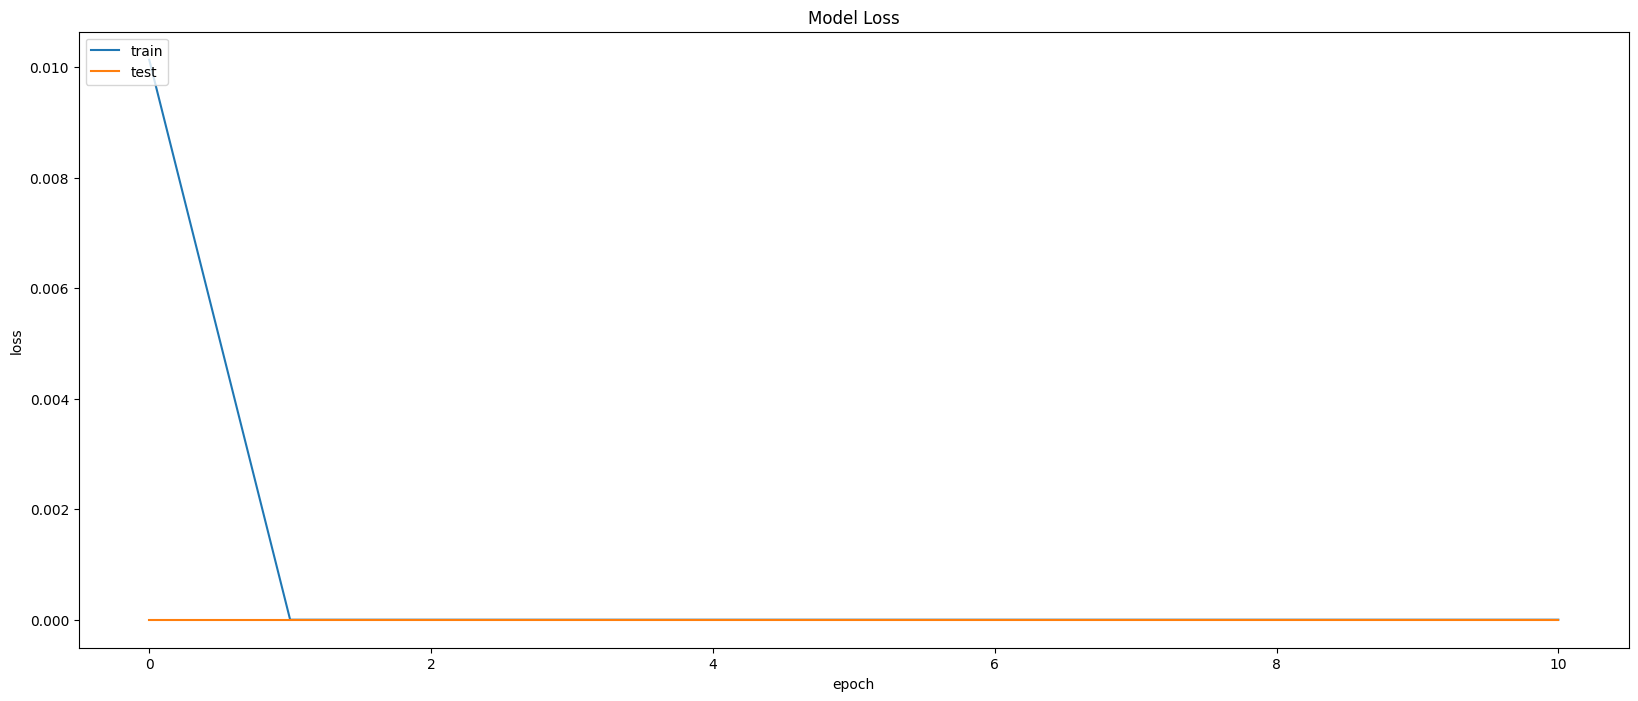

In [41]:
# Loss plot
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
model.save('facial_emotion_recognition_model.h5')